In [1]:
import numpy as np
from numpy import *
from numpy.linalg import *
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import ranksums, ttest_ind, entropy, pearsonr
from scipy.io import savemat, loadmat
from scipy.stats import entropy
from pyentrp import entropy as ent
import scipy.stats as stats
from random import *
from itertools import combinations
from pylab import *
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import zlib
import os
import scipy.io
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

### Statistical Complexity

In [3]:
def calculate(istring: str, dl: int, sigma: float = 0.05, method: str = "overlapping",
                                     states_provided: bool = False, return_states: bool = False):
    """
    Find the (forwards) Statistical Complexity of an input string for given lambda and sigma values
    """
    #if states are not provided, find them, otherwise declare it
    if(type(states_provided)==bool):
        #first, find all states from the input string and the probabilities of presents
        initial_states = find_states(istring,dl,method=method)
        #next, collapse states which have similar probability distributions
        refined_states = collapse_states(initial_states,dl,sigma)
    else:
        #collapse the states based purely on keynames (already done)
        initial_states,refined_states = states_provided,states_provided
    #convert this into a list of probabilities
    probs = collapse_past(refined_states)
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    #if states are not desired, only return complexity
    if(return_states==False):
        return complexity
    else:
        return complexity,refined_states,initial_states

def calculate_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the (forwards) Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate(string,dl,sigma))
    return output

def calculate_bd(istring: str, dl: int, sigma: float = 0.05, method: str ="overlapping",
                              record_states: bool = False):
    """
    Find the forwards, reverse and bidirectional statistical complexity for a string
    """
    #find statistical complexity of forward string and the refined states
    f_sc,f_states,f_states_raw = calculate(istring,dl,sigma,return_states=True,method=method)
    #find complexity of backwards string
    b_sc,b_states,b_states_raw = calculate(istring[::-1],dl,sigma,return_states=True,method=method)
    #collapse the states of forward and reverse complexity based purely on key names
    bd_s = collapse_keys(f_states,b_states)
    #find complexity of bi-directional machine
    bd_sc,bd_states,bd_states_raw = calculate("",dl,sigma,states_provided = bd_s,return_states = True)
    if(record_states==False):
        return f_sc,b_sc,bd_sc
    else:
        return f_sc,b_sc,bd_sc,len(f_states),len(b_states),len(bd_states),len(f_states_raw),len(b_states_raw),len(bd_states_raw)

#Find multiple statistical complexities for forwards, reverse and bidirectional
def calculate_bd_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the forwards, reverse and bidirectional Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate_bd(string,dl,sigma))
    return output

#input string, desired lambda
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions
    """
    #variables used
    i,output_dict = 0,{}
    ## main loop of identifying past and present states
    # Option 1: Non Overlapping
    if(method=="nonoverlapping"):
        while(i+(dl*2)<len(istring)):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=dl
    #Option 2: Overlapping
    else:
        while(i+dl+1<len(istring)):
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=1
    # The last state discovery (main loop misses the final state that can be found)
    try:
        if(method=="nonoverlapping"):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
        else:
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
        if(past not in output_dict):
            output_dict.update({past: {present:1,"total":1}})
        else:
            if(present not in output_dict[past]):
                output_dict[past].update({present:1})
            else:
                output_dict[past][present]+=1
            output_dict[past]["total"]+=1
    except:
        pass
    #collapse counts into probabilities with total counts
    for past in output_dict:
        for present in output_dict[past]:
            if(present!="total"):
                output_dict[past][present]/=output_dict[past]["total"]
    return output_dict

def collapse_states(odict: dict, dl: int, sigma: float = 0.1):
    """
    Collapse a dictionary of state counts into practical states based on a permitted difference sigma
    """
    # Newdict is the collapsed dictionary, temp is used to override newdict when necessary,
    # done_checker is a dictionary used to record the keys already compared
    newdict,temp,done_checker = deepcopy(odict),False,{}
    while(True):
        # If temp is not a boolean, i.e. it's become a dictionary, override newdict
        if(type(temp)!=bool):
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if(past1 not in done_checker):
                done_checker[past1] = {}
            for past2 in newdict:
                if(past1!=past2):
                    if(past2 not in done_checker[past1]):
                        done_checker[past1][past2] = True
                    else:
                        # If these states have already been checked, don't bother checking them again
                        continue
                    # If the difference is less than sigma, merge these states and break the past2 loop
                    if(calculate_difference(newdict[past1],newdict[past2])<sigma):
                        temp = merge_states(newdict,past1,past2,dl)
                        break
            # If the dictionary must be updated, break the past1 loop
            if(type(temp)!=bool):
                break
        # If temp is still a boolean, i.e. there was no merging of states in this loop, break the main loop
        if(type(temp)==bool):
            break
    return newdict

def calculate_difference(past1: dict, past2: dict):
    """
    Calculate the difference between two past states' present state distributions
    """
    difference = -np.inf
    # Cycle through past 1 and check for max differences
    for present in past1:
        # Ensure this check isn't being performed on the total state count
        if(present!="total"):
            if(present not in past2):
                difference = max(difference,past1[present])
            else:
                difference = max(difference,abs(past1[present]-past2[present]))
    # Cycle through past 2
    for present in past2:
        if(present!="total"):
            if(present not in past1):
                difference = max(difference,past2[present])
    return difference

def merge_states(odict: dict, past1: dict, past2: dict, dl: int):
    """
    Merge 2 states and their present state distributions, creating a new state key in a standardised manner
    """
    nprobs = {}
    for present in odict[past1]:
        if(present in odict[past2]):
            nprobs.update({present:(odict[past1][present]+odict[past2][present])/2})
        else:
            nprobs.update({present:odict[past1][present]/2})
    for present in odict[past2]:
        if(present not in odict[past1]):
            nprobs.update({present:odict[past2][present]/2})
    nprobs.update({"total":odict[past1]["total"]+odict[past2]["total"]})
    #create a sorted version of the two pasts combined
    temp,to_sort = past1+past2,[]
    for i in range(int(len(temp)/dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while(len(to_sort)>0):
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    #add the new key and remove the old ones
    ndict = deepcopy(odict)
    ndict.update({newkey:nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

#collapse dictionary of past states and future states into an array of probabilities of the past states
def collapse_past(odict):
    """
    Collapse a dictionary of past states with present state distribtuions into an array of probabilities of the past states
    """
    probs,i,total = np.zeros(len(odict),dtype=float),0,0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i+=1
    return probs/total

def collapse_keys(d1: dict, d2: dict):
    """
    Merge 2 dictionaries of past states with present state distributions
    Note: keys present in both dictionaries lose their probability distributions and only the "total" key remains,
          but this is all that is needed by the point they are merged
    """
    ndict = {}
    for key in d1:
        # as longer keys are created and sorted in a standard way, they are all standardised
        temp = False
        if(key in d2):
            #if the key is in d2, add the two together and mark this has been done
            ndict.update({key:{"total":d1[key]["total"]+d2[key]["total"]}})
            temp = True
        #if no variant of the key was found in d2, add the key as-is
        if(temp==False):
            ndict.update({key:d1[key]})
    for key in d2:
        if(key not in ndict):
            ndict.update({key:d2[key]})
    return ndict

def probs_to_complexity(probs):
    """
    Calculate the Statistical Complexity given an array of past state probabilities
    """
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    # Correct any 0-probabilities to become 0 rather than infinity
    for i in range(len(logprobs)):
        if(probs[i]==0): logprobs[i] = 0.
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    return complexity

def binarise(data,mode="median"):
    """
    Binarise an array of continuous numbers into an array of 0's and 1's (as a string)
    """
    if(type(data)==list or type(data)==tuple):
        data=np.array(data,dtype=float)
    if(isinstance(data,np.ndarray)==False):
        return "Unusable datatype {}".format(type(data))
    if(mode=="median"):
        threshold=np.median(data)
    elif(mode=="mean"):
        threshold=np.mean(data)
    output = np.zeros([len(data)],dtype=int)
    for i in range(len(data)):
        if(data[i]>=threshold):
            output[i]+=1
    # Convert to string
    outstr = ""
    for element in output:
        outstr += str(element)
    return outstr

def multi_binarise(matrix,mode="median"):
    """
    Binarise a 2D matrix (used for calculating multiple statistical complexities)    
    """
    print("Binarising data...")
    # Convert to numpy matrix
    if(type(matrix)==list or type(matrix)==tuple):
        matrix=np.array(matrix,dtype=object)
    output = []
    percent_check = 0.
    for i in range(len(matrix)):
        output.append(binarise(matrix[i],mode))
        # Output progress
        if((i+1)/float(len(matrix))>=percent_check/100.):
            print("{}% of data binarised".format(\
                round(((i+1)/len(matrix))*100,1)))
            percent_check+=10.
    print("Data Binarised")
    return np.array(output, dtype = object)

### Lempel-Ziv Complexity

In [5]:
'''
Python code to compute LZc complexity measure as described in "Complexity of multi-dimensional spontaneous EEG decreases during propofol induced general anaesthesia"

Author: m.schartner@sussex.ac.uk
Date: 09.12.14

To compute Lempel-Ziv complexity for continuous multidimensional time series X, where rows are time series (minimum 2), and columns are observations, type the following in ipython: 
 
execfile('CompMeasures.py')
LZc(X)
'''

def Pre(X):
 '''
 Detrend and normalize input data, X a multidimensional time series
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro):
  Z[i,:]=signal.detrend(X[i,:]-mean(X[i,:]), axis=0)
 return Z


##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
'''
##########

def cpr(string):
    """
    Lempel-Ziv-Welch compression of binary input string, e.g., string='0010101'.
    It outputs the size of the dictionary of binary words.
    """
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZc_binary(string):
    """
    Compute LZ complexity for a binary string and normalize it using a shuffled result.
    """
    # Shuffling the string
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    # Calculate complexities
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity by the shuffled result if shuffled_complexity is not zero
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity


def str_col(X):
 '''
 Input: Continuous multidimensional time series
 Output: One string being the binarized input matrix concatenated comlumn-by-column
 '''
 ro,co=shape(X)
 TH=zeros(ro)
 M=zeros((ro,co))
 for i in range(ro):
  M[i,:]=abs(hilbert(X[i,:]))
  TH[i]=mean(M[i,:])

 s=''
 for j in xrange(co):
  for i in xrange(ro):
   if M[i,j]>TH[i]:
    s+='1'
   else:
    s+='0'

 return s

def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))

### MVAR Model

In [7]:
# Define functions
def statdata(A, npoints):
    """
    Generate time-series data for a Gaussian MVAR(p) process with a non-linear transformation
    X_t = tanh(A_1 * X_{t-1} + A_2 * X_{t-2} + ... + A_p * X_{t-p} + E_t)
    
    Args:
    - A (numpy.ndarray): Generalized connectivity matrix. Shape (nvar, nvar * p)
    - npoints (int): Number of data points to generate
    
    Returns:
    - X (numpy.ndarray): Time-series data with a non-linear tanh transformation. Shape (nvar, npoints)
    """
    
    settle = 500  # Number of initial points to discard to allow the process to settle
    N = npoints + settle  # Total number of points including the settling period
    nvar = A.shape[0]  # Number of variables (dimensionality of the time-series)
    p = A.shape[1] // nvar  # The order of the MVAR process
    
    # Initialize time-series data with Gaussian noise
    X = np.random.normal(0, 1, (nvar, N))
    
    # Generate data based on the MVAR model
    for i in range(p, N):
        for j in range(nvar):
            for k in range(nvar):
                for m in range(p):
                    # Linear combination of past p values with connectivity matrix A
                    X[j, i] += A[j, k + m * nvar] * X[k, i - m - 1]
            # Apply non-linear tanh transformation
            X[j, i] = np.tanh(X[j, i])
    
    # Return only post-equilibrium data points
    return X[:, settle:]

### Run Simulation

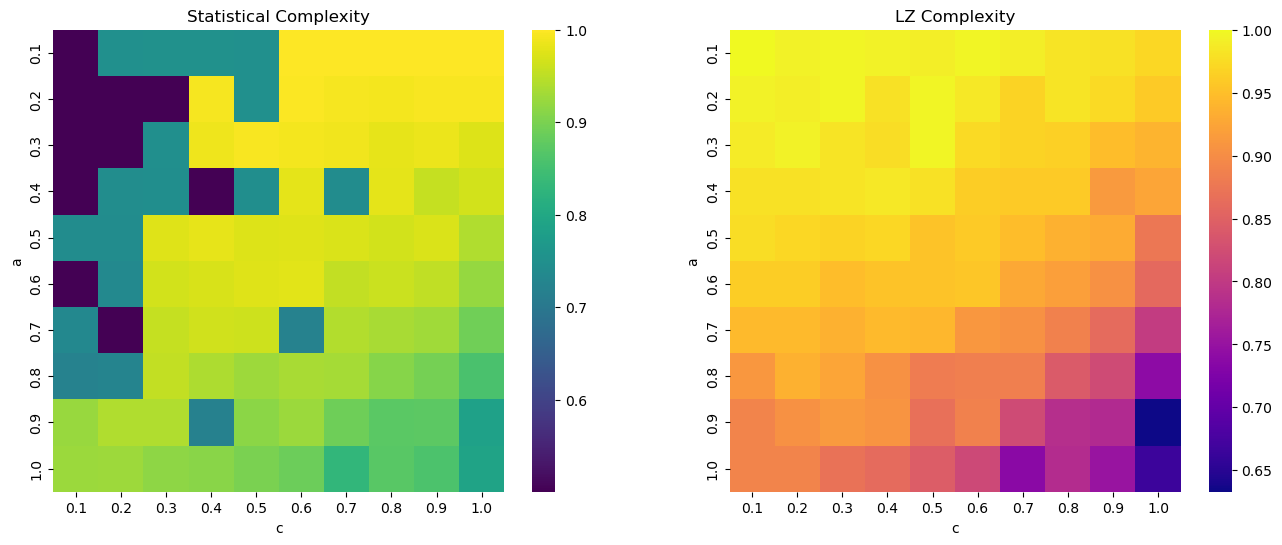

In [9]:
def LZc_binary(sequence):
    # Convert the sequence to a binary string
    binary_string = ''.join(map(str, sequence))
    # Calculate the Lempel-Ziv complexity of the binary string
    return cpr(binary_string)

def add_white_noise(data, noise_level):
    # Generate white noise with the specified noise level
    noise = np.random.normal(0, noise_level, size=data.shape)
    # Add the noise to the data
    return data + noise

def binarize_data(data, threshold):
    # Binarize the data based on the given threshold
    return (data > threshold).astype(int)

def calculate_statistical_complexity(sequence, lambda_val, sigma_val):
    # Convert the sequence to a binary string
    binary_string = ''.join(map(str, sequence))
    # Calculate the statistical complexity of the binary string
    return calculate(binary_string, lambda_val, sigma=sigma_val)


# Parameters
nvar = 2  # Number of variables
p = 1  # Order of the MVAR process
npoints = 1000  # Number of data points
noise_level = 0.05  # Noise level for white noise
a_values = np.linspace(0.1, 1.0, 10)  # Range of coupling strength values
c_values = np.linspace(0.1, 1.0, 10)  # Range of noise correlation values

# Initialize matrices to store results
stat_complexities = np.zeros((len(a_values), len(c_values)))
lz_complexities = np.zeros((len(a_values), len(c_values)))

# Loop over all combinations of a_values and c_values
for i, a in enumerate(a_values):
    for j, c in enumerate(c_values):
        # Create the connectivity matrix
        A = np.array([[a, c], [c, a]])
        # Generate time-series data
        data = statdata(A, npoints)
        # Add white noise to the data
        data_noisy = add_white_noise(data, noise_level)
        
        # Binarize the noisy data
        binary_data = binarize_data(data_noisy.flatten(), np.median(data_noisy))
        
        # Calculate statistical complexity
        stat_complexity = calculate_statistical_complexity(binary_data, lambda_val=2, sigma_val=0.05)
        # Calculate Lempel-Ziv complexity
        lz_complexity = LZc_binary(binary_data)
        
        # Store the complexities in the matrices
        stat_complexities[i, j] = stat_complexity
        lz_complexities[i, j] = lz_complexity

# Normalize the complexity matrices
stat_complexities /= stat_complexities.max()
lz_complexities /= lz_complexities.max()

# Plot heat maps
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the statistical complexity heat map
sns.heatmap(stat_complexities, ax=axs[0], xticklabels=np.round(c_values, 2), yticklabels=np.round(a_values, 2), cmap='viridis')
axs[0].set_title('Statistical Complexity')
axs[0].set_xlabel('c')
axs[0].set_ylabel('a')

# Plot the Lempel-Ziv complexity heat map
sns.heatmap(lz_complexities, ax=axs[1], xticklabels=np.round(c_values, 2), yticklabels=np.round(a_values, 2), cmap='plasma')
axs[1].set_title('LZ Complexity')
axs[1].set_xlabel('c')
axs[1].set_ylabel('a')

# Show the plots
plt.show()

### Statistical Analysis

Compute some quantitative measures and perform hypothesis testing to validate the observed patterns in complexity measures.

In [11]:
# Convert matrices to dataframes for better manipulation and analysis
df_stat_complexity = pd.DataFrame(stat_complexities, index=a_values, columns=c_values)
df_lz_complexity = pd.DataFrame(lz_complexities, index=a_values, columns=c_values)

# Calculate descriptive statistics
stat_desc = df_stat_complexity.describe()
lz_desc = df_lz_complexity.describe()

print("Statistical Complexity Descriptive Statistics:\n", stat_desc)
print("LZ Complexity Descriptive Statistics:\n", lz_desc)

# Calculate correlation between SC and LZ complexities
correlation_matrix = np.corrcoef(df_stat_complexity.values.flatten(), df_lz_complexity.values.flatten())
print("Correlation between SC and LZ complexities:", correlation_matrix[0, 1])

# Flatten data for hypothesis testing
sc_values = df_stat_complexity.values.flatten()
lz_values = df_lz_complexity.values.flatten()

# Define regions for high and low complexities
high_sc_values = sc_values[sc_values > np.median(sc_values)]
low_sc_values = sc_values[sc_values <= np.median(sc_values)]

high_lz_values = lz_values[lz_values > np.median(lz_values)]
low_lz_values = lz_values[lz_values <= np.median(lz_values)]

# Perform two-sample t-tests
t_stat_sc, p_value_sc = ttest_ind(high_sc_values, low_sc_values)
t_stat_lz, p_value_lz = ttest_ind(high_lz_values, low_lz_values)

print("Two-sample t-test for SC - t-statistic: {:.2f}, p-value: {:.4f}".format(t_stat_sc, p_value_sc))
print("Two-sample t-test for LZ - t-statistic: {:.2f}, p-value: {:.4f}".format(t_stat_lz, p_value_lz))

Statistical Complexity Descriptive Statistics:
              0.1        0.2        0.3        0.4        0.5        0.6  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.654674   0.706701   0.845125   0.871533   0.889188   0.938712   
std     0.177161   0.162292   0.155314   0.163426   0.101671   0.084677   
min     0.500383   0.500383   0.500383   0.500383   0.745190   0.721141   
25%     0.500383   0.556801   0.747756   0.790539   0.787543   0.927009   
50%     0.610739   0.738676   0.928013   0.951629   0.920022   0.976211   
75%     0.739618   0.748294   0.955174   0.979037   0.971077   0.987766   
max     0.924473   0.940936   0.975452   0.992706   0.995972   1.000000   

             0.7        0.8        0.9        1.0  
count  10.000000  10.000000  10.000000  10.000000  
mean    0.924281   0.946411   0.941661   0.911913  
std     0.083102   0.047665   0.050421   0.079092  
min     0.740666   0.871130   0.859307   0.784934  
25%     0.900333

### 1. Descriptive Statistics Visualizations

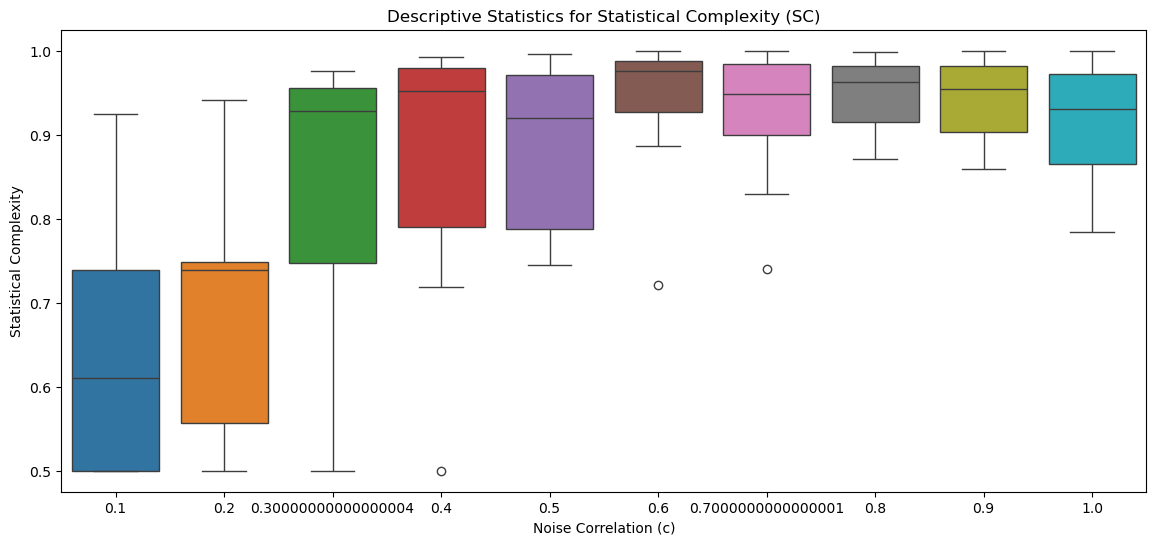

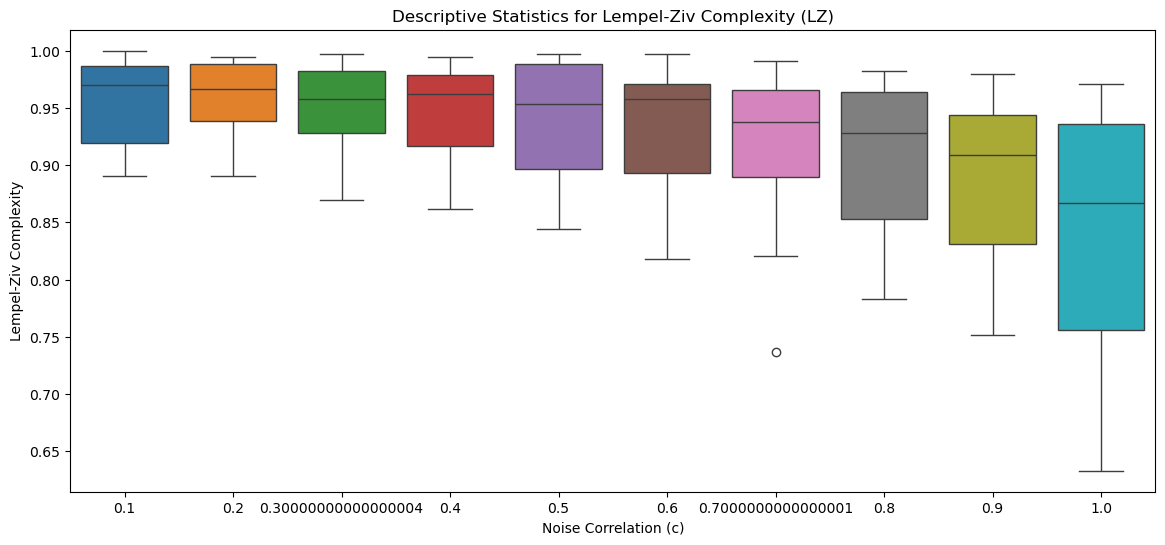

In [13]:
# Descriptive statistics visualizations for SC
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_stat_complexity)
plt.title('Descriptive Statistics for Statistical Complexity (SC)')
plt.xlabel('Noise Correlation (c)')
plt.ylabel('Statistical Complexity')

plt.show()

# Descriptive statistics visualizations for LZ
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_lz_complexity)
plt.title('Descriptive Statistics for Lempel-Ziv Complexity (LZ)')
plt.xlabel('Noise Correlation (c)')
plt.ylabel('Lempel-Ziv Complexity')

plt.show()

### 2. Correlation Visualization

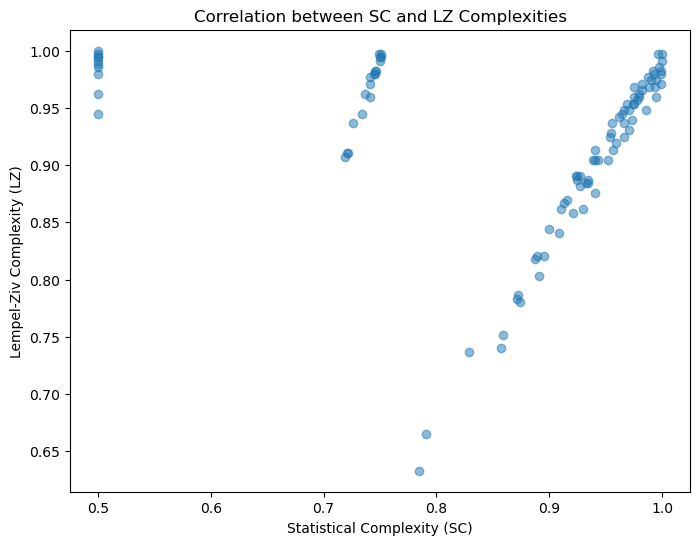

In [15]:
# Scatter plot to visualize the correlation between SC and LZ
plt.figure(figsize=(8, 6))
plt.scatter(df_stat_complexity.values.flatten(), df_lz_complexity.values.flatten(), alpha=0.5)
plt.title('Correlation between SC and LZ Complexities')
plt.xlabel('Statistical Complexity (SC)')
plt.ylabel('Lempel-Ziv Complexity (LZ)')
plt.show()

### 3. Hypothesis Testing Results Visualization

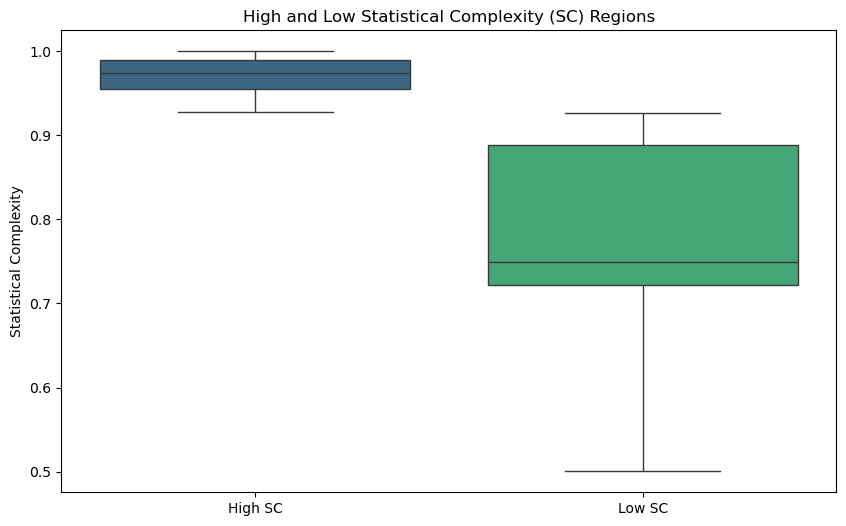

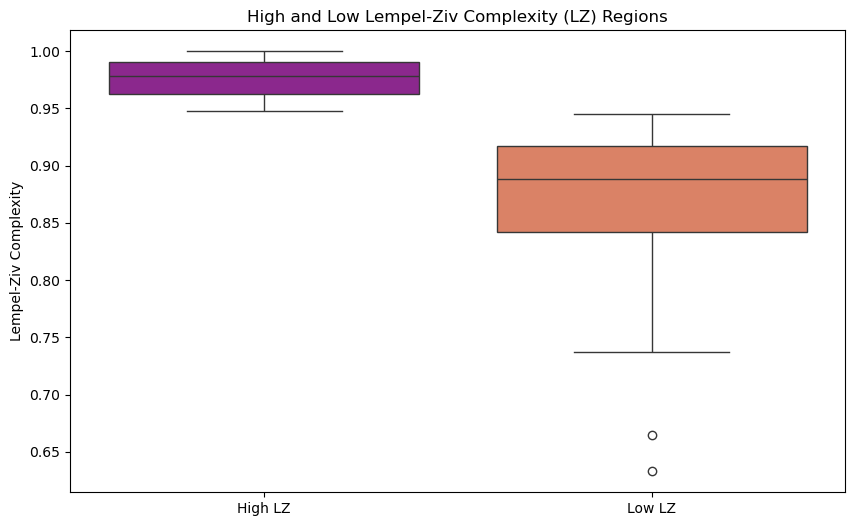

In [17]:
# Visualization of high and low SC regions
plt.figure(figsize=(10, 6))
sns.boxplot(data=[high_sc_values, low_sc_values], palette='viridis')
plt.title('High and Low Statistical Complexity (SC) Regions')
plt.xticks([0, 1], ['High SC', 'Low SC'])
plt.ylabel('Statistical Complexity')
plt.show()

# Visualization of high and low LZ regions
plt.figure(figsize=(10, 6))
sns.boxplot(data=[high_lz_values, low_lz_values], palette='plasma')
plt.title('High and Low Lempel-Ziv Complexity (LZ) Regions')
plt.xticks([0, 1], ['High LZ', 'Low LZ'])
plt.ylabel('Lempel-Ziv Complexity')
plt.show()

### Enhanced Visualization

#### 1. 3D Surface Plots
3D surface plots to visualize how SC and LZc change across the entire parameter space of coupling strength $(a)$ and noise correlation $(c)$.

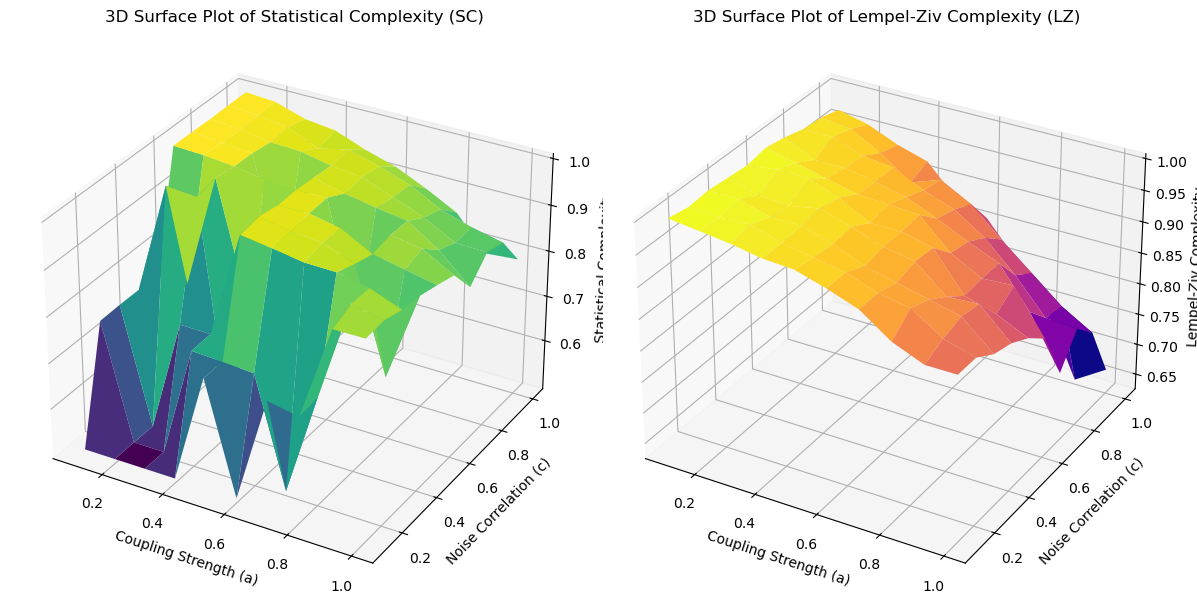

In [19]:
# Prepare grids for plotting
a_grid, c_grid = np.meshgrid(a_values, c_values)

# 3D Plot for Statistical Complexity (SC)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(a_grid, c_grid, df_stat_complexity.values.T, cmap='viridis')
ax.set_title('3D Surface Plot of Statistical Complexity (SC)')
ax.set_xlabel('Coupling Strength (a)')
ax.set_ylabel('Noise Correlation (c)')
ax.set_zlabel('Statistical Complexity')

# 3D Plot for Lempel-Ziv Complexity (LZ)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(a_grid, c_grid, df_lz_complexity.values.T, cmap='plasma')
ax.set_title('3D Surface Plot of Lempel-Ziv Complexity (LZ)')
ax.set_xlabel('Coupling Strength (a)')
ax.set_ylabel('Noise Correlation (c)')
ax.set_zlabel('Lempel-Ziv Complexity')

plt.tight_layout()
plt.show()

#### 2. Contour Plots
Contour plots provide another perspective by showing lines of constant complexity values, making it easier to see how the complexities change with the parameters.

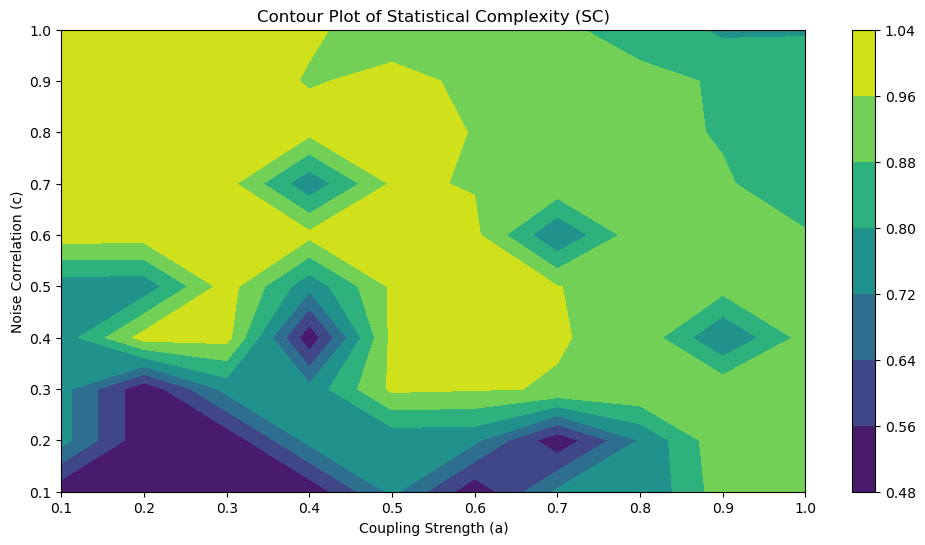

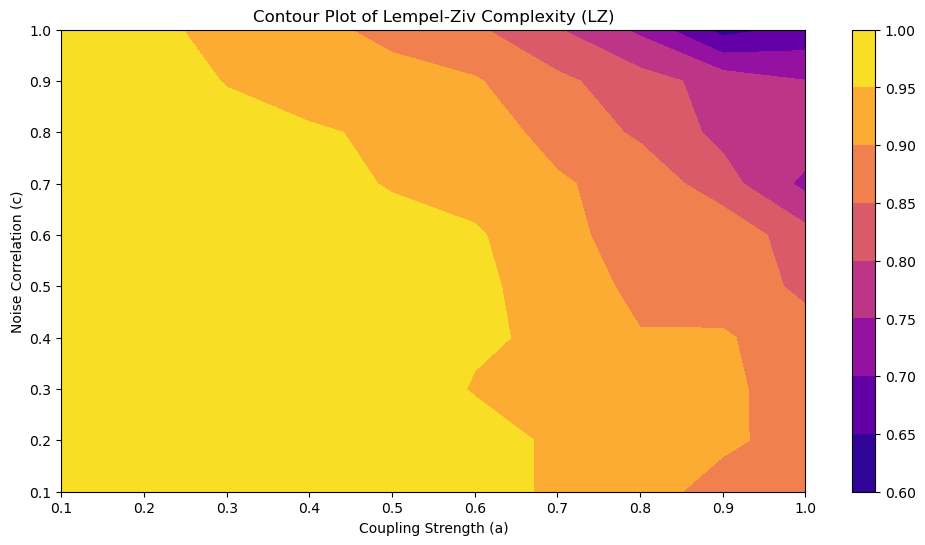

In [21]:
# Contour Plot for Statistical Complexity (SC)
plt.figure(figsize=(12, 6))
cp = plt.contourf(a_grid, c_grid, df_stat_complexity.values.T, cmap='viridis')
plt.colorbar(cp)
plt.title('Contour Plot of Statistical Complexity (SC)')
plt.xlabel('Coupling Strength (a)')
plt.ylabel('Noise Correlation (c)')
plt.show()

# Contour Plot for Lempel-Ziv Complexity (LZ)
plt.figure(figsize=(12, 6))
cp = plt.contourf(a_grid, c_grid, df_lz_complexity.values.T, cmap='plasma')
plt.colorbar(cp)
plt.title('Contour Plot of Lempel-Ziv Complexity (LZ)')
plt.xlabel('Coupling Strength (a)')
plt.ylabel('Noise Correlation (c)')

plt.show()